# Import et env

In [1]:
from datetime import datetime

import math
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling as pp 

In [2]:
ls 

sample_data/


In [3]:
!apt-get update  > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession

Customisation of the memory attributed to Spark

In [5]:
# spark = SparkSession.builder.enableHiveSupport().master("local[*]").getOrCreate()

spark = SparkSession.builder\
  .config('spark.executor.memory', '10g')\
  .config('spark.driver.memory', '10g')\
  .enableHiveSupport().master("local[*]").getOrCreate()

In [6]:
from pyspark.sql.functions import col
from pyspark.sql.types import *

from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [7]:
from fbprophet import Prophet

In [ ]:
# !pip freeze >> /content/drive/MyDrive/Colab\ Notebooks/Ynov\ -\ Major\ -\ Big\ data/3-\ Projet\ Forecast/requirements.txt

In [8]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [9]:
!ls -l

total 227880
drwx------  6 root root      4096 Dec 18 13:33 drive
drwxr-xr-x  1 root root      4096 Dec  2 22:04 sample_data
drwxr-xr-x 13 1000 1000      4096 Sep  8 05:48 spark-2.4.7-bin-hadoop2.7
-rw-r--r--  1 root root 233333392 Sep  8 07:13 spark-2.4.7-bin-hadoop2.7.tgz


We can generate a configuration file to regenerate an environment outside of Google Colab

In [10]:
!ls /content/drive/MyDrive/Colab\ Notebooks/Ynov\ -\ Major\ -\ Big\ data/3-\ Projet\ Forecast/

data				     requirements.txt  Tp-Engie-Forecast.ipynb
Presentation-Engie-Forecast.gslides  sujets


Here it's possible to choose the location of the datas

In [11]:
datas = '/content/drive/MyDrive/Colab\ Notebooks/Ynov\ -\ Major\ -\ Big\ data/3-\ Projet\ Forecast/data/part-00000-tid-7836136960911133305-62557da9-0991-4369-b089-a33b842d2798-503-1-c000\ (2).csv'
# datas = 'data/part-00000-tid-7836136960911133305-62557da9-0991-4369-b089-a33b842d2798-503-1-c000 (2).csv'

Structure of the CSV file

| client_id | date | heure (UTC) | minute | value |
|-|-|-|-|-|
| 2d31eca9696a3243e19e8d36c4054d08 | 2019-03-14 | 0 | 0 | 13 |
| 2d31eca9696a3243e19e8d36c4054d08 | 2019-03-14 | 0 | 10 | 14 |
| 2d31eca9696a3243e19e8d36c4054d08 | 2019-03-14 | 0 | 20 | 13 |

In [12]:
df = spark.read.csv(datas)

In [13]:
df.count()

21661806

In [14]:
df = df.withColumnRenamed('_c0', 'client_id')
df = df.withColumnRenamed('_c1', 'date')
df = df.withColumnRenamed('_c2', 'heure')
df = df.withColumnRenamed('_c3', 'minute')
df = df.withColumnRenamed('_c4', 'valeur')

# Datalake

## Parquet size optimization

- Repartition 3 = perfect (230mo)

In [15]:
df.repartition(3).write.mode('overwrite').partitionBy('date').parquet('forecast')

Size of directory generate by the datalake

In [16]:
!ls forecast/ | wc -l

153


Size of Parquet's file inside a few directory

In [17]:
!ls -l forecast/date=2019-03-14

total 636
-rw-r--r-- 1 root root 213855 Dec 18 13:35 part-00000-2e30187d-8d8a-4b78-9a71-f62c53011eff.c000.snappy.parquet
-rw-r--r-- 1 root root 215594 Dec 18 13:35 part-00001-2e30187d-8d8a-4b78-9a71-f62c53011eff.c000.snappy.parquet
-rw-r--r-- 1 root root 214090 Dec 18 13:35 part-00002-2e30187d-8d8a-4b78-9a71-f62c53011eff.c000.snappy.parquet


In [18]:
!ls -l forecast/date=2019-03-29

total 612
-rw-r--r-- 1 root root 207424 Dec 18 13:35 part-00000-2e30187d-8d8a-4b78-9a71-f62c53011eff.c000.snappy.parquet
-rw-r--r-- 1 root root 207311 Dec 18 13:35 part-00001-2e30187d-8d8a-4b78-9a71-f62c53011eff.c000.snappy.parquet
-rw-r--r-- 1 root root 206703 Dec 18 13:35 part-00002-2e30187d-8d8a-4b78-9a71-f62c53011eff.c000.snappy.parquet


## Importing parquet into lake

In [19]:
df.printSchema()

root
 |-- client_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- heure: string (nullable = true)
 |-- minute: string (nullable = true)
 |-- valeur: string (nullable = true)



In [20]:
spark.sql('DROP TABLE IF EXISTS forecast')

spark.sql("CREATE TABLE forecast (client_id STRING, date STRING, heure STRING, minute STRING, valeur STRING) USING PARQUET PARTITIONED BY (date) LOCATION '/content/forecast'")

DataFrame[]

In [21]:
spark.sql('MSCK REPAIR TABLE forecast')

DataFrame[]

In [22]:
spark.sql('SHOW PARTITIONS forecast').count()

152

In [23]:
df = spark.sql('SELECT * from forecast')

In [24]:
df.count()

21661806

# Data exploration

## Having an overall idea of a single client datas

In [25]:
spark.sql("SELECT count(distinct(*)) FROM forecast WHERE client_id='2d31eca9696a3243e19e8d36c4054d08'").show()

+------------------------------------------------------+
|count(DISTINCT client_id, heure, minute, valeur, date)|
+------------------------------------------------------+
|                                                 21888|
+------------------------------------------------------+



In [26]:
spark.sql("SELECT * FROM forecast WHERE client_id='2d31eca9696a3243e19e8d36c4054d08'").show()

+--------------------+-----+------+------+----------+
|           client_id|heure|minute|valeur|      date|
+--------------------+-----+------+------+----------+
|2d31eca9696a3243e...|   14|    20|   166|2019-03-18|
|2d31eca9696a3243e...|   11|    20|    11|2019-03-18|
|2d31eca9696a3243e...|   21|    30|    14|2019-03-18|
|2d31eca9696a3243e...|   18|    10|    13|2019-03-18|
|2d31eca9696a3243e...|   14|     0|   148|2019-03-18|
|2d31eca9696a3243e...|    5|    20|    11|2019-03-18|
|2d31eca9696a3243e...|   11|    50|    14|2019-03-18|
|2d31eca9696a3243e...|    3|    10|    11|2019-03-18|
|2d31eca9696a3243e...|    7|    40|    16|2019-03-18|
|2d31eca9696a3243e...|    3|    40|    11|2019-03-18|
|2d31eca9696a3243e...|   22|    10|    15|2019-03-18|
|2d31eca9696a3243e...|   15|    30|    79|2019-03-18|
|2d31eca9696a3243e...|    2|    20|    11|2019-03-18|
|2d31eca9696a3243e...|   11|    30|    11|2019-03-18|
|2d31eca9696a3243e...|    7|    50|    16|2019-03-18|
|2d31eca9696a3243e...|    2|

In [27]:
df.groupBy('client_id', 'date').count().show()

+--------------------+----------+-----+
|           client_id|      date|count|
+--------------------+----------+-----+
|53db8c6450449dba9...|2019-03-18|  144|
|1d6a556c62ae4f872...|2019-03-18|  144|
|7e825f37a2a409279...|2019-03-18|  144|
|f03158b5a01856421...|2019-03-18|  144|
|5699c6bfdf13a18f8...|2019-03-18|  144|
|d59969183d9c5a4c3...|2019-03-18|  144|
|ac151486848248f8a...|2019-03-21|  144|
|bc048a5c20f59484f...|2019-03-21|  144|
|90e0c399707712c07...|2019-03-21|  144|
|e34890382b33794f7...|2019-03-21|  144|
|c6434bd5696710532...|2019-03-21|  144|
|deb807112e0fdcd6b...|2019-03-21|  144|
|fc1386a35b19de600...|2019-03-21|  144|
|463caa3a0ae6b6820...|2019-03-21|  144|
|a3b39e47316e27581...|2019-04-18|  144|
|12088f09f91573138...|2019-04-18|  144|
|3e15abd3576267d49...|2019-04-18|  144|
|20497476892abe985...|2019-04-18|  144|
|fc1386a35b19de600...|2019-04-18|  144|
|5ed91b3bdebe3c67e...|2019-02-22|  144|
+--------------------+----------+-----+
only showing top 20 rows



## Client consummation over time

In [28]:
spark.sql('SELECT client_id, sum(valeur) as conso, date FROM forecast where client_id="2d31eca9696a3243e19e8d36c4054d08" and date between "2019-01-01" and "2019-06-01" group by date , client_id').show()

+--------------------+-------+----------+
|           client_id|  conso|      date|
+--------------------+-------+----------+
|2d31eca9696a3243e...| 3295.0|2019-02-14|
|2d31eca9696a3243e...| 1759.0|2019-02-16|
|2d31eca9696a3243e...| 1507.0|2019-03-17|
|2d31eca9696a3243e...| 1733.0|2019-05-05|
|2d31eca9696a3243e...| 2020.0|2019-03-08|
|2d31eca9696a3243e...| 4890.0|2019-05-10|
|2d31eca9696a3243e...|19971.0|2019-01-23|
|2d31eca9696a3243e...| 1201.0|2019-05-01|
|2d31eca9696a3243e...| 1295.0|2019-04-27|
|2d31eca9696a3243e...| 1663.0|2019-02-21|
|2d31eca9696a3243e...| 2496.0|2019-05-02|
|2d31eca9696a3243e...| 1252.0|2019-05-18|
|2d31eca9696a3243e...| 1725.0|2019-02-17|
|2d31eca9696a3243e...| 2193.0|2019-01-20|
|2d31eca9696a3243e...|  922.0|2019-05-23|
|2d31eca9696a3243e...|14795.0|2019-01-09|
|2d31eca9696a3243e...| 1847.0|2019-01-13|
|2d31eca9696a3243e...| 1935.0|2019-02-10|
|2d31eca9696a3243e...| 1374.0|2019-03-16|
|2d31eca9696a3243e...|11790.0|2019-01-08|
+--------------------+-------+----

#### Daily consummation

In [29]:
daily = spark.sql("SELECT client_id, date, cast(heure as int), sum(valeur) as valeur FROM forecast where client_id='2d31eca9696a3243e19e8d36c4054d08' and date='2019-03-05' group by Date, client_id, cast(heure as int) order by date, cast(heure as int)")

daily.show()

+--------------------+----------+-----+------+
|           client_id|      date|heure|valeur|
+--------------------+----------+-----+------+
|2d31eca9696a3243e...|2019-03-05|    0|  79.0|
|2d31eca9696a3243e...|2019-03-05|    1|  80.0|
|2d31eca9696a3243e...|2019-03-05|    2|  80.0|
|2d31eca9696a3243e...|2019-03-05|    3|  81.0|
|2d31eca9696a3243e...|2019-03-05|    4|  78.0|
|2d31eca9696a3243e...|2019-03-05|    5|  80.0|
|2d31eca9696a3243e...|2019-03-05|    6|  80.0|
|2d31eca9696a3243e...|2019-03-05|    7|  99.0|
|2d31eca9696a3243e...|2019-03-05|    8| 115.0|
|2d31eca9696a3243e...|2019-03-05|    9| 100.0|
|2d31eca9696a3243e...|2019-03-05|   10|  96.0|
|2d31eca9696a3243e...|2019-03-05|   11|  79.0|
|2d31eca9696a3243e...|2019-03-05|   12|  71.0|
|2d31eca9696a3243e...|2019-03-05|   13|  67.0|
|2d31eca9696a3243e...|2019-03-05|   14|  65.0|
|2d31eca9696a3243e...|2019-03-05|   15|  72.0|
|2d31eca9696a3243e...|2019-03-05|   16|  59.0|
|2d31eca9696a3243e...|2019-03-05|   17|  64.0|
|2d31eca9696a

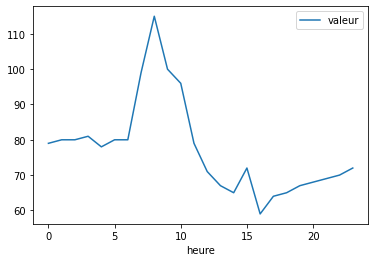

In [30]:
daily.toPandas().plot('heure', 'valeur')

#### Weekly consummation

In [31]:
weekly = spark.sql("SELECT client_id, date, cast(heure as int), sum(valeur) as valeur FROM forecast where client_id='2d31eca9696a3243e19e8d36c4054d08' and date between '2019-03-08' and '2019-03-16' group by Date, client_id, cast(heure as int) order by date, cast(heure as int)")

weekly.show()

+--------------------+----------+-----+------+
|           client_id|      date|heure|valeur|
+--------------------+----------+-----+------+
|2d31eca9696a3243e...|2019-03-08|    0|  83.0|
|2d31eca9696a3243e...|2019-03-08|    1|  76.0|
|2d31eca9696a3243e...|2019-03-08|    2|  78.0|
|2d31eca9696a3243e...|2019-03-08|    3|  77.0|
|2d31eca9696a3243e...|2019-03-08|    4|  76.0|
|2d31eca9696a3243e...|2019-03-08|    5|  77.0|
|2d31eca9696a3243e...|2019-03-08|    6|  76.0|
|2d31eca9696a3243e...|2019-03-08|    7|  81.0|
|2d31eca9696a3243e...|2019-03-08|    8| 290.0|
|2d31eca9696a3243e...|2019-03-08|    9| 168.0|
|2d31eca9696a3243e...|2019-03-08|   10|  77.0|
|2d31eca9696a3243e...|2019-03-08|   11|  79.0|
|2d31eca9696a3243e...|2019-03-08|   12|  66.0|
|2d31eca9696a3243e...|2019-03-08|   13|  70.0|
|2d31eca9696a3243e...|2019-03-08|   14|  70.0|
|2d31eca9696a3243e...|2019-03-08|   15|  74.0|
|2d31eca9696a3243e...|2019-03-08|   16|  57.0|
|2d31eca9696a3243e...|2019-03-08|   17|  57.0|
|2d31eca9696a

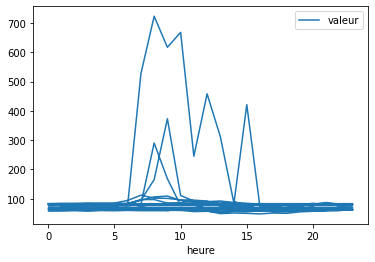

In [32]:
weekly.toPandas().plot('heure', 'valeur')

#### Montly consummation

In [33]:
monthly = spark.sql("SELECT client_id, date, cast(heure as int), sum(valeur) as valeur FROM forecast where client_id='2d31eca9696a3243e19e8d36c4054d08' and date between '2019-03-08' and '2019-04-18' group by Date, client_id, cast(heure as int) order by date, cast(heure as int)")\
.toPandas()

monthly

,client_id,date,heure,valeur
0,2d31eca9696a3243e19e8d36c4054d08,2019-03-08,0,83.0
1,2d31eca9696a3243e19e8d36c4054d08,2019-03-08,1,76.0
2,2d31eca9696a3243e19e8d36c4054d08,2019-03-08,2,78.0
3,2d31eca9696a3243e19e8d36c4054d08,2019-03-08,3,77.0
4,2d31eca9696a3243e19e8d36c4054d08,2019-03-08,4,76.0
...,...,...,...,...
1003,2d31eca9696a3243e19e8d36c4054d08,2019-04-18,19,41.0
1004,2d31eca9696a3243e19e8d36c4054d08,2019-04-18,20,42.0
1005,2d31eca9696a3243e19e8d36c4054d08,2019-04-18,21,41.0
1006,2d31eca9696a3243e19e8d36c4054d08,2019-04-18,22,51.0


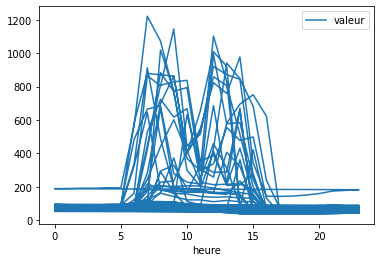

In [34]:
monthly.plot('heure', 'valeur')

# Étape 1 - Clustering

### 1.1 Shaping hour from UTC to local Time

In [35]:
df = spark.sql("SELECT *, CONCAT (date, ' ', cast(heure as int), ':', minute, ':00') AS datetime FROM forecast"); 
df.show()

+--------------------+-----+------+------+----------+-------------------+
|           client_id|heure|minute|valeur|      date|           datetime|
+--------------------+-----+------+------+----------+-------------------+
|671dafda52d56a7c1...|   22|     0|    84|2019-03-18| 2019-03-18 22:0:00|
|d7d32080f087314ff...|    3|    20|   118|2019-03-18| 2019-03-18 3:20:00|
|5b53d32032d797058...|   18|    20|   254|2019-03-18|2019-03-18 18:20:00|
|d8730ec6d7e832509...|   14|     0|   156|2019-03-18| 2019-03-18 14:0:00|
|30cf726217ea085ef...|   10|    50|   510|2019-03-18|2019-03-18 10:50:00|
|60f7a8085885ffc2e...|   17|    10|    79|2019-03-18|2019-03-18 17:10:00|
|d1562c4f5a5ed4a82...|    6|    40|   257|2019-03-18| 2019-03-18 6:40:00|
|71830988c1c8d007d...|    7|    10|    27|2019-03-18| 2019-03-18 7:10:00|
|a8acfb3e85bcce2c7...|    8|    10|   328|2019-03-18| 2019-03-18 8:10:00|
|e7d578fe2dc2e35d6...|    6|    40|   149|2019-03-18| 2019-03-18 6:40:00|
|236bb8209514bdd27...|    5|    50|   

In [36]:
from pyspark.sql.functions import to_timestamp

df_date = df.withColumn("date_to_datetime", to_timestamp(col("datetime"))); 
df_date.show()

+--------------------+-----+------+------+----------+-------------------+-------------------+
|           client_id|heure|minute|valeur|      date|           datetime|   date_to_datetime|
+--------------------+-----+------+------+----------+-------------------+-------------------+
|671dafda52d56a7c1...|   22|     0|    84|2019-03-18| 2019-03-18 22:0:00|2019-03-18 22:00:00|
|d7d32080f087314ff...|    3|    20|   118|2019-03-18| 2019-03-18 3:20:00|2019-03-18 03:20:00|
|5b53d32032d797058...|   18|    20|   254|2019-03-18|2019-03-18 18:20:00|2019-03-18 18:20:00|
|d8730ec6d7e832509...|   14|     0|   156|2019-03-18| 2019-03-18 14:0:00|2019-03-18 14:00:00|
|30cf726217ea085ef...|   10|    50|   510|2019-03-18|2019-03-18 10:50:00|2019-03-18 10:50:00|
|60f7a8085885ffc2e...|   17|    10|    79|2019-03-18|2019-03-18 17:10:00|2019-03-18 17:10:00|
|d1562c4f5a5ed4a82...|    6|    40|   257|2019-03-18| 2019-03-18 6:40:00|2019-03-18 06:40:00|
|71830988c1c8d007d...|    7|    10|    27|2019-03-18| 2019-0

In [37]:
from pyspark.sql.functions import unix_timestamp

df = (df_date
    .select("client_id", "valeur", "date_to_datetime")
    .withColumn("unix_timestamp", unix_timestamp("date_to_datetime", "yyyy-MM-dd HH:mm:ss"))
    .withColumn("GMT + 1", 3600 + unix_timestamp("date_to_datetime", "yyyy-MM-dd HH:mm:ss"))
    )

df.show()

+--------------------+------+-------------------+--------------+----------+
|           client_id|valeur|   date_to_datetime|unix_timestamp|   GMT + 1|
+--------------------+------+-------------------+--------------+----------+
|671dafda52d56a7c1...|    84|2019-03-18 22:00:00|    1552946400|1552950000|
|d7d32080f087314ff...|   118|2019-03-18 03:20:00|    1552879200|1552882800|
|5b53d32032d797058...|   254|2019-03-18 18:20:00|    1552933200|1552936800|
|d8730ec6d7e832509...|   156|2019-03-18 14:00:00|    1552917600|1552921200|
|30cf726217ea085ef...|   510|2019-03-18 10:50:00|    1552906200|1552909800|
|60f7a8085885ffc2e...|    79|2019-03-18 17:10:00|    1552929000|1552932600|
|d1562c4f5a5ed4a82...|   257|2019-03-18 06:40:00|    1552891200|1552894800|
|71830988c1c8d007d...|    27|2019-03-18 07:10:00|    1552893000|1552896600|
|a8acfb3e85bcce2c7...|   328|2019-03-18 08:10:00|    1552896600|1552900200|
|e7d578fe2dc2e35d6...|   149|2019-03-18 06:40:00|    1552891200|1552894800|
|236bb820951

### 1.2 Clustering

In [38]:
spark.sql('select client_id, count(distinct(date)) ctd from forecast group by client_id having ctd < (select(DATEDIFF(max(date), min(date))+1) as target from forecast) order by ctd desc').show()

+--------------------+---+
|           client_id|ctd|
+--------------------+---+
|5699c6bfdf13a18f8...|150|
|802920640f66e0573...|150|
|78979327bd515ee8e...|150|
|fa83698bf5baf581f...|150|
|9e7fc4a954f2067d2...|148|
|1c7a366e2318c4b12...|147|
|9884b39d7cef07c0b...|146|
|fb0ae8f6ad62dc1aa...|146|
|30d1186c59caa3cff...|146|
|1415397b411661176...|146|
|3c442dd04d1431851...|146|
|a7d59f5dd38e64b80...|146|
|506dc1a595a4f835c...|145|
|74fe77c3abb7329cc...|145|
|4cac3fb637139dd47...|145|
|447da4ed5c2684ef0...|145|
|c506b74ea6081c48a...|145|
|2ef42fafd481d2422...|145|
|2224babb617474482...|145|
|02dc1396e1419bb67...|145|
+--------------------+---+
only showing top 20 rows



In [39]:
# Requete sql somme des conso par jour et par client
# Inner join sur les clients qui ont toute les données
rqtest = spark.sql(" SELECT d.client_id \
            , d.Date \
            , avg(cast(d.valeur as int)) Value \
            FROM forecast d \
            INNER JOIN (select client_id, count(distinct(date)) ctd from forecast group by client_id having ctd = (select (DATEDIFF(max(date), min(date))+1) as target from forecast) order by ctd asc) c on d.client_id = c.client_id\
            group by d.client_id, d.date order by d.client_id, d.Date \
            ")
rqtest.show()

+--------------------+----------+------------------+
|           client_id|      Date|             Value|
+--------------------+----------+------------------+
|000376cc92b42bcc0...|2019-01-01|176.93055555555554|
|000376cc92b42bcc0...|2019-01-02|223.60416666666666|
|000376cc92b42bcc0...|2019-01-03|233.36111111111111|
|000376cc92b42bcc0...|2019-01-04|222.58333333333334|
|000376cc92b42bcc0...|2019-01-05|168.25694444444446|
|000376cc92b42bcc0...|2019-01-06|167.15972222222223|
|000376cc92b42bcc0...|2019-01-07|251.96527777777777|
|000376cc92b42bcc0...|2019-01-08|           252.625|
|000376cc92b42bcc0...|2019-01-09|241.65277777777777|
|000376cc92b42bcc0...|2019-01-10|245.74305555555554|
|000376cc92b42bcc0...|2019-01-11|          240.1875|
|000376cc92b42bcc0...|2019-01-12|161.20833333333334|
|000376cc92b42bcc0...|2019-01-13|163.57638888888889|
|000376cc92b42bcc0...|2019-01-14|240.49305555555554|
|000376cc92b42bcc0...|2019-01-15|241.31944444444446|
|000376cc92b42bcc0...|2019-01-16|          228

Pivotage :tada:

In [40]:
# Pivotage - somme des conso par jour et par client
dftest = rqtest.groupby(rqtest.client_id).pivot("Date").max("Value")
dftest.show()
# Nb de client conforme
dftest.count()

+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------

913

In [41]:
def collect_entire_row(row):
  array = []
  for item in range(1, len(row)):
    array.append(row[item])
  return array

vector2test = dftest.rdd\
  .map(lambda f: [f[0], DenseVector(collect_entire_row(f))])\
  .collect()

In [42]:
vector3test = spark.createDataFrame(vector2test)

# Fill NA -> si on est chaud on replace par la valeur moyenne de la ligne
vector3test = vector3test.na.fill(1)

# Renomer les colonne pour le kmeans
vector3test = vector3test.withColumnRenamed('_1', 'label')
vector3test = vector3test.withColumnRenamed('_2', 'features')
vector3test.show()

+--------------------+--------------------+
|               label|            features|
+--------------------+--------------------+
|336adcb8516290939...|[68.0902777777777...|
|410592d73a5ca7d26...|[37.2986111111111...|
|90e0c399707712c07...|[224.673611111111...|
|a82c41200a12a8f9b...|[163.347222222222...|
|1a6fd0f0b2a309e4e...|[136.3125,133.805...|
|215f20c52789d44ae...|[58.6597222222222...|
|bf9f98891d6c2c58e...|[277.423611111111...|
|c5b3c0616cbea56aa...|[58.0972222222222...|
|f9b76c066408e82f5...|[134.666666666666...|
|25b3a75c54394d895...|[153.909722222222...|
|77b384cc5065370e1...|[142.743055555555...|
|8488c616ab5618cc3...|[121.0,129.472222...|
|003fb3fda1752eae6...|[168.326388888888...|
|53eab9af4560d7870...|[109.465277777777...|
|75ff56c8b89c56b36...|[54.8402777777777...|
|9db19c6085d50008e...|[20.3819444444444...|
|c60a98d3f684e36c7...|[193.972222222222...|
|c6434bd5696710532...|[111.6875,128.597...|
|d3c5b29217bd0270b...|[96.4513888888888...|
|d4e9a3da548544754...|[163.49305

Vérification du type de schéma, on attend une colonne 'features' de type `vector`

In [43]:
vector3test.printSchema()
vector3test.count()

root
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)



913

In [64]:
# Nombre de groupe
nb_cluster = 12

# Kmeans
modeltest = KMeans().setK(nb_cluster).setSeed(1).fit(vector3test)
predictions_cluster = modeltest.transform(vector3test)

In [65]:
predictions_cluster.show()

+--------------------+--------------------+----------+
|               label|            features|prediction|
+--------------------+--------------------+----------+
|336adcb8516290939...|[68.0902777777777...|         5|
|410592d73a5ca7d26...|[37.2986111111111...|         3|
|90e0c399707712c07...|[224.673611111111...|         9|
|a82c41200a12a8f9b...|[163.347222222222...|         0|
|1a6fd0f0b2a309e4e...|[136.3125,133.805...|         0|
|215f20c52789d44ae...|[58.6597222222222...|         5|
|bf9f98891d6c2c58e...|[277.423611111111...|         9|
|c5b3c0616cbea56aa...|[58.0972222222222...|         4|
|f9b76c066408e82f5...|[134.666666666666...|         4|
|25b3a75c54394d895...|[153.909722222222...|         2|
|77b384cc5065370e1...|[142.743055555555...|         8|
|8488c616ab5618cc3...|[121.0,129.472222...|         4|
|003fb3fda1752eae6...|[168.326388888888...|         1|
|53eab9af4560d7870...|[109.465277777777...|         5|
|75ff56c8b89c56b36...|[54.8402777777777...|         8|
|9db19c608

In [46]:
predictions_cluster.count()

913

## 1.3 Cost function by client

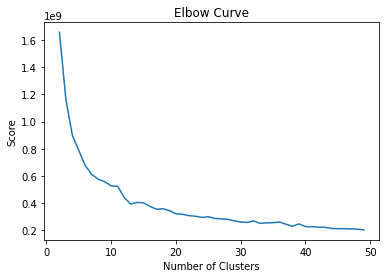

In [47]:
import numpy as np
cost = np.zeros(50)

for k in range(2,50):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(vector3test)
    cost[k] = model.summary.trainingCost

df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

# Étape 2 - Unitary prediction

## Complexity abstraction

In [66]:
def get_cluster_id_by_client(client_id):
  rdd = predictions_cluster\
    .filter(predictions_cluster['label'] == client_id)\
    .first()
  return rdd['prediction']

In [67]:
def get_cluster_df_by_id(id_cluster):
  rdd = predictions_cluster\
    .drop('features')\
    .filter(predictions_cluster['prediction'] == id_cluster)\
    .collect()
  return spark.createDataFrame(rdd)

In [68]:
def generate_consumation_dataframe_by_client_id(client_id):
    cluster_id = get_cluster_id_by_client(client_id)
    print('cluster_id', cluster_id)

    df_cluster = get_cluster_df_by_id(cluster_id)

    # On crééer un dataframe avec les valeurs moyennés pour tous nos clients
    daily = spark.sql("SELECT client_id, TO_DATE(CAST(UNIX_TIMESTAMP(date, 'yyyy-MM-dd') AS TIMESTAMP)) as ds, avg(valeur) as valeur FROM forecast GROUP BY Date, client_id ORDER BY date")

    # Jointure entre les consommation horaires/quotidienne et un groupe (cluster) client
    df = df_cluster.join(
      daily,
      daily['client_id'] == df_cluster['label'],
      'inner')
    
    df = df.drop('client_id')
    df = df.withColumnRenamed('valeur', 'Y')
    return df

In [69]:
def prediction_from_dataframe(to_forecast):
  to_forecast = to_forecast.groupBy('ds').avg('Y')

  # Courbe normalisé des consommations pour le cluster choisis
  to_forecast = to_forecast.withColumnRenamed('avg(Y)', 'y')
  to_forecast = to_forecast.toPandas()

  model = Prophet(
      interval_width=0.95,
      growth='linear',
      daily_seasonality=False,
      weekly_seasonality=True,
      yearly_seasonality=True,
      seasonality_mode='multiplicative'
  )
  model.fit(to_forecast)

  future_pd = model.make_future_dataframe(
      periods=30,
      freq='d',
      include_history=True
  )

  forecast_pd = model.predict(future_pd)
  model.plot(forecast_pd, xlabel='date', ylabel='kW')
  # display(model_fig)

In [70]:
def generate_prediction(client_id):
  df = generate_consumation_dataframe_by_client_id(client_id)
  return prediction_from_dataframe(df)

## Predictions for a specific client

Here we can pick up a few `client_id` in order to use them later and generate prediction plot.

In [71]:
spark.sql('SELECT * FROM forecast').show(35, truncate=False)

+--------------------------------+-----+------+------+----------+
|client_id                       |heure|minute|valeur|date      |
+--------------------------------+-----+------+------+----------+
|671dafda52d56a7c10b37093b300f880|22   |0     |84    |2019-03-18|
|d7d32080f087314ff9405473fd177c68|3    |20    |118   |2019-03-18|
|5b53d32032d797058b1260aa23b2d576|18   |20    |254   |2019-03-18|
|d8730ec6d7e832509d2699396d240ca1|14   |0     |156   |2019-03-18|
|30cf726217ea085eff81bac5245c38fb|10   |50    |510   |2019-03-18|
|60f7a8085885ffc2e0ea7ea86c002676|17   |10    |79    |2019-03-18|
|d1562c4f5a5ed4a820b07268dcf7ac6e|6    |40    |257   |2019-03-18|
|71830988c1c8d007d961fce2680ca8f3|7    |10    |27    |2019-03-18|
|a8acfb3e85bcce2c7ff83dd4c628057a|8    |10    |328   |2019-03-18|
|e7d578fe2dc2e35d648b100d1354db52|6    |40    |149   |2019-03-18|
|236bb8209514bdd27b04d3ec7b19e410|5    |50    |552   |2019-03-18|
|fe6931336e85bb0c10aa057407b59cfb|21   |20    |66    |2019-03-18|
|0985df6d8

cluster_id 9


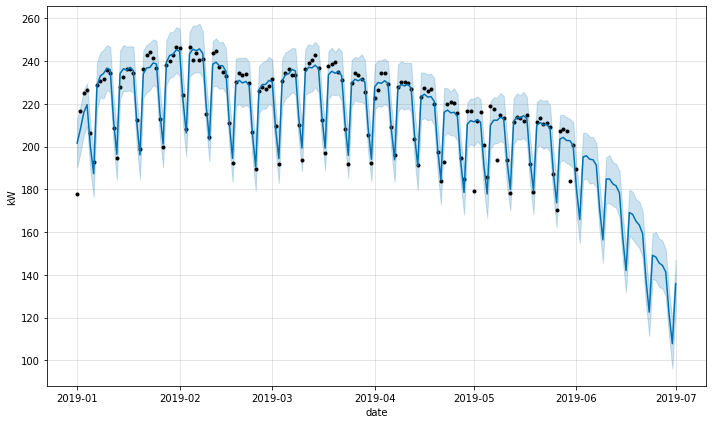

In [72]:
client_id = '70079c4dff9f801c341b0a74d6ff22f8'
generate_prediction(client_id)

cluster_id 5


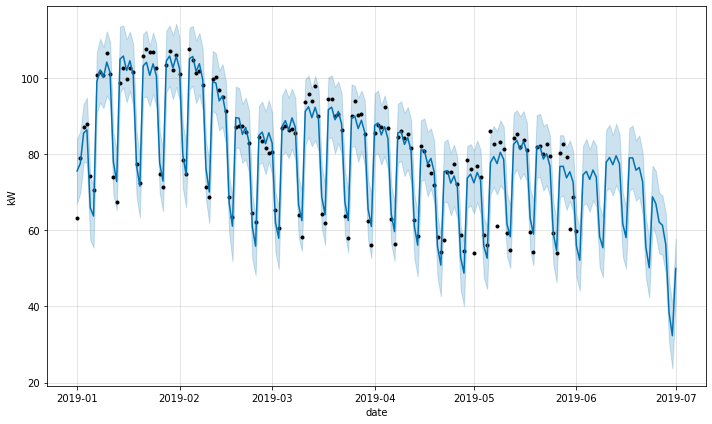

In [73]:
client_id = '336adcb85162909390c8ef800ec9bea7'
generate_prediction(client_id)

cluster_id 10


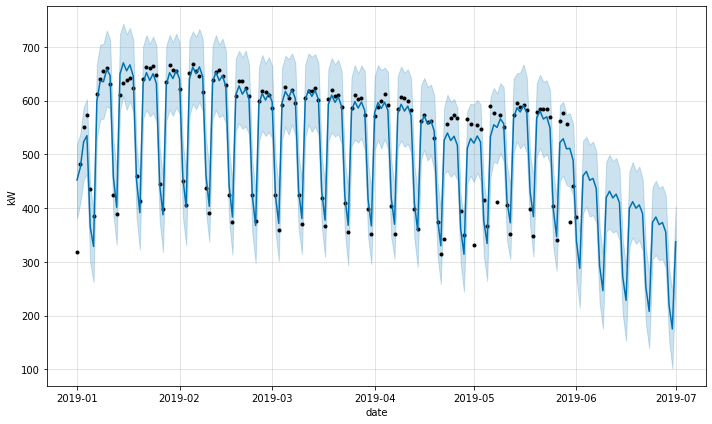

In [74]:
client_id = '236bb8209514bdd27b04d3ec7b19e410'
generate_prediction(client_id)

## Exploring different seasonality

### 1

In [73]:
nom_client = "'336adcb85162909390c8ef800ec9bea7'"
GraphClient = spark.sql("SELECT client_id,TO_DATE(CAST(UNIX_TIMESTAMP(date, 'yyyy-MM-dd') AS TIMESTAMP)) as ds, avg(valeur) as y FROM forecast where client_id = {} group by client_id, date order by client_id, ds".format(nom_client))

In [74]:
GraphClient = GraphClient.toPandas()

In [75]:
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)

model.fit(GraphClient)

In [76]:
future_pd = model.make_future_dataframe(
    periods=30,
    freq='d',
    include_history=True
)

- daily_seasonality=False,
- weekly_seasonality=True,
- yearly_seasonality=True,

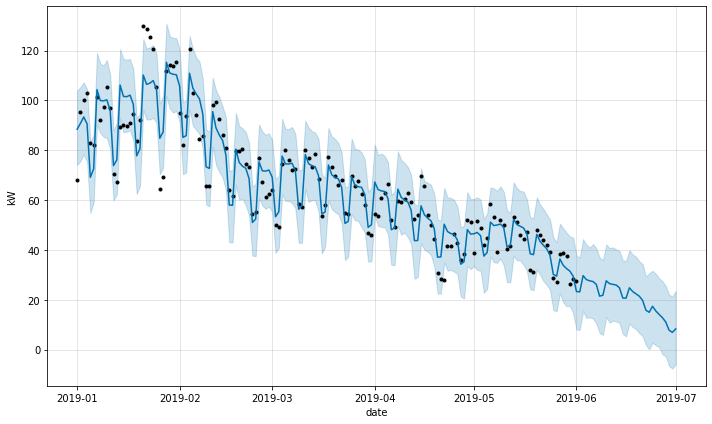

In [ ]:
forecast_pd = model.predict(future_pd)
predict_fig = model.plot(forecast_pd, xlabel='date', ylabel='kW')

In [ ]:
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False,
    seasonality_mode='multiplicative'
)

model.fit(GraphClient)

In [ ]:
future_pd = model.make_future_dataframe(
    periods=30,
    freq='d',
    include_history=True
)

### 2

- daily_seasonality=False,
- weekly_seasonality=True,
- yearly_seasonality=False,

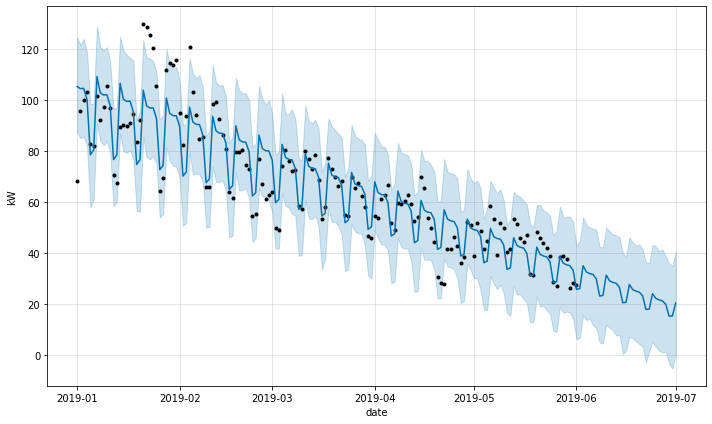

In [ ]:
forecast_pd = model.predict(future_pd)
predict_fig = model.plot(forecast_pd, xlabel='date', ylabel='kW')

### 3

- daily_seasonality=True,
- weekly_seasonality=True,
- yearly_seasonality=False,

In [ ]:
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    seasonality_mode='multiplicative'
)

model.fit(GraphClient)

In [ ]:
future_pd = model.make_future_dataframe(
    periods=30,
    freq='d',
    include_history=True
)

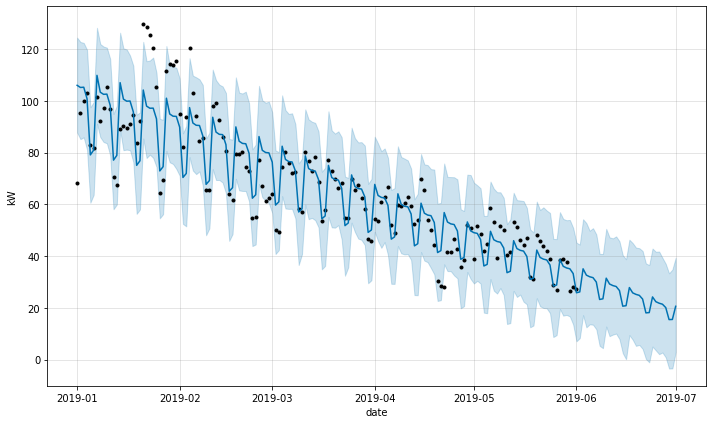

In [ ]:
forecast_pd = model.predict(future_pd)
predict_fig = model.plot(forecast_pd, xlabel='date', ylabel='kW')

### 4

Après plusieurs essais on c'est rendus compte que le paramètre `weekly seasonality` devait être à `True` si on ne voulait pas générer une Régression linéaire de type `f(x) = ax + b` ou Régression polynomiale de type `f(x) = ax**ax + bx + c`

- daily_seasonality=True,
- weekly_seasonality=False,
- yearly_seasonality=True,

In [ ]:
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=True,
    weekly_seasonality=False,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)

model.fit(GraphClient)

In [ ]:
future_pd = model.make_future_dataframe(
    periods=30,
    freq='d',
    include_history=True
)

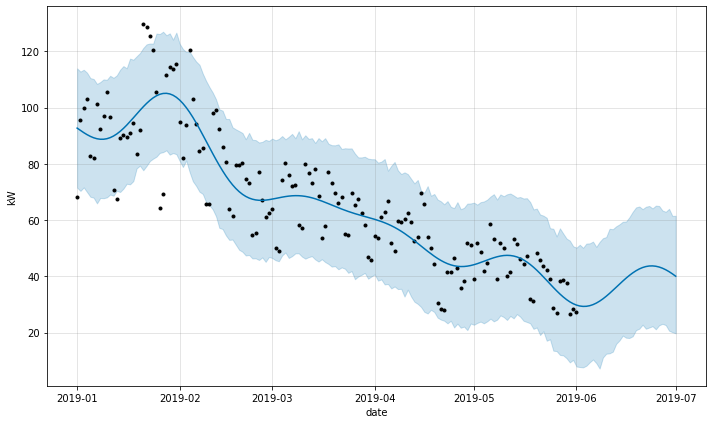

In [ ]:
forecast_pd = model.predict(future_pd)
predict_fig = model.plot(forecast_pd, xlabel='date', ylabel='kW')

## Globale prediction

In [ ]:
sumDate = spark.sql("SELECT TO_DATE(CAST(UNIX_TIMESTAMP(date, 'yyyy-MM-dd') AS TIMESTAMP)) AS ds, max(cast(valeur as int)) AS y FROM forecast where date is not null GROUP BY date ORDER BY date asc")

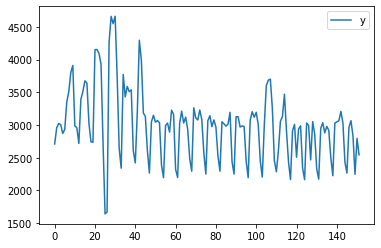

In [ ]:
res = sumDate.select(sumDate["y"], sumDate["ds"]).toPandas()
res.plot();

In [ ]:
# instantiate the model and set parameters
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    seasonality_mode='multiplicative'
)

In [ ]:
# fit the model to historical data
model.fit(res)

In [ ]:
future_pd = model.make_future_dataframe(
    periods=90,
    freq='d',
    include_history=True
)

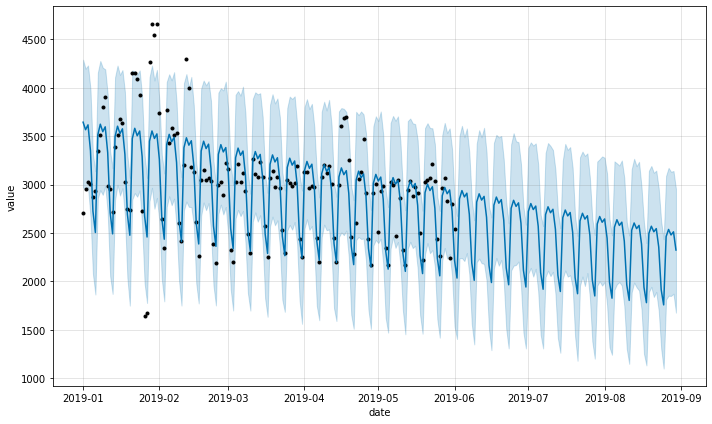

In [ ]:
forecast_pd = model.predict(future_pd)
predict_fig = model.plot(forecast_pd, xlabel='date', ylabel='value')

# Étape 3 - Dashboard

## Generating dashboard for client

We can imagine those function act as API's HTTP request.

In [75]:
def Dashboard(nom_client, datedebut, datefin, Nb_jour_Predictions):
   
  DashClient = spark.sql("SELECT client_id as client_id,Date, round(avg(cast(valeur as int)),2) as valeur FROM forecast where client_id = "+ nom_client +" and date between "+datedebut+" and "+datefin+" \
   group by client_id,date order by client_id,date");

  #ConsoMax , Consomini et MoyenneConso pour le client choisi
  StatClient = spark.sql("SELECT client_id as client, round(max(cast(valeur as int)),2) as maxConsoJour,round(min(cast(valeur as int)),2) as minConsoJour,round(avg(cast(valeur as int)),2) as moyenneConsoJour FROM forecast where client_id = "+ nom_client +" and date between "+datedebut+" and "+datefin+" \
   group by client_id order by client_id");
  StatClient.show()

  #Pivotage - somme des conso par jour et pour le client choisi
  ConsoClient = DashClient.groupby(DashClient.client_id).pivot("Date").avg("valeur")
  ConsoClient.toPandas()
  ConsoClient.select(ConsoClient.client_id).count()

  #Consomation par jour pour le client choisi 
  nom_client = "'65b3f280ee4b46b48f521b92335401ba'"
  GraphClient = spark.sql("SELECT client_id,TO_DATE(CAST(UNIX_TIMESTAMP(date, 'yyyy-MM-dd') AS TIMESTAMP)) as ds,avg(valeur)as y FROM forecast where client_id = "+ nom_client +" and date between "+datedebut+" and "+datefin+" group by client_id, date order by client_id, ds")
  res = GraphClient.select(GraphClient["y"], GraphClient["ds"])
  
  return prediction_from_dataframe(res)

In [76]:
  def DashboardAvance(nom_client,datedebut,datefin):
    # MoyenneConso par mois
    StatClient = spark.sql("SELECT client_id as client, \
    Case month(date) when 1 then 'Janvier' when 2 then 'Fevrier' when 3 then 'Mars' when 4 then 'Avril' when 5 then 'Mai' when 6 then 'juin' when 7 then 'Juillet' when 8 then 'Aout' when 9 then 'Septembre' when 10 then 'Octobre' when 11 then 'Novembre' when 12 then 'Decembre'end as Mois,\
    round((avg(cast(valeur as int))),2) as moyenneConsoMois FROM forecast where client_id = "+ nom_client +" and date between "+datedebut+" and "+datefin+" group by   month(date),client_id order by month(date),client_id");
    StatClient.drop('client').show()

    #Moyenne Conso par jour de la semaine
    StatClient = spark.sql("SELECT client_id as client, Case DAYOFWEEK(date) when 1 then 'dimanche' when 2 then 'lundi' when 3 then 'mardi' when 4 then 'mercredi' when 5 then 'jeudi' when 6 then 'vendredi' when 7 then 'samedi' end as jour , round((avg(cast(valeur as int))),2) as moyenneConsoJour \
    FROM forecast where client_id = "+ nom_client +" and date between "+datedebut+" and "+datefin+" \
    group by  jour ,client_id order by jour ,client_id");
    StatClient.drop('client').show()

    #Moyenne Conso par heure
    StatClient = spark.sql("SELECT client_id as client, cast(heure as int) as heure,  round((avg(cast(valeur as int))),2) as moyenneConsoHeure FROM forecast where client_id = "+ nom_client +" and date between "+datedebut+" and "+datefin+" group by   cast(heure as int),client_id order by cast(heure as int),client_id");
    StatClient.drop('client').show()

+--------------------+------------+------------+----------------+
|              client|maxConsoJour|minConsoJour|moyenneConsoJour|
+--------------------+------------+------------+----------------+
|65b3f280ee4b46b48...|         136|          49|           82.46|
+--------------------+------------+------------+----------------+



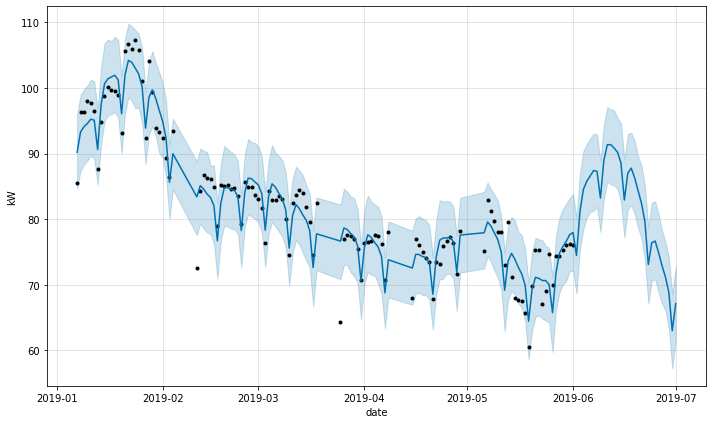

In [77]:
nom_client = "'65b3f280ee4b46b48f521b92335401ba'"
datedebut = "'2019-01-07'"
datefin = "'2019-06-01'"
Nb_jour_Predictions = 30

Dashboard(nom_client, datedebut, datefin, Nb_jour_Predictions)

In [78]:
DashboardAvance(nom_client, datedebut, datefin)

+-------+----------------+
|   Mois|moyenneConsoMois|
+-------+----------------+
|Janvier|           98.83|
|Fevrier|           85.44|
|   Mars|           79.99|
|  Avril|           75.21|
|    Mai|           73.24|
|   juin|           76.04|
+-------+----------------+

+--------+----------------+
|    jour|moyenneConsoJour|
+--------+----------------+
|dimanche|           76.72|
|   jeudi|           83.37|
|   lundi|           84.07|
|   mardi|           84.09|
|mercredi|           83.92|
|  samedi|           81.83|
|vendredi|           82.99|
+--------+----------------+

+-----+-----------------+
|heure|moyenneConsoHeure|
+-----+-----------------+
|    0|            71.25|
|    1|            71.64|
|    2|            71.37|
|    3|             75.7|
|    4|            81.39|
|    5|            85.15|
|    6|            91.72|
|    7|             87.4|
|    8|             82.0|
|    9|            82.79|
|   10|             81.1|
|   11|            80.74|
|   12|            80.26|
|   

## Loss function (RMSE) and prediction coefficient by client

In [85]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [108]:
def split_dataset(input_dataset):
  index_ds = len(input_dataset)

  train_set = input_dataset[int(index_ds *.8):]
  test_set = input_dataset[:int(index_ds *.2)]
  
  return train_set, test_set

Calculer le delta entre la courbe normalisé du cluster et le client -> coef

Appliquer le coef sur la courbe du client

Calculer l'erreur (RMSE) sur la courbe du cluster et l'appliquer sur le client

In [94]:
def prediction_from_dataframe(to_forecast):
  to_forecast = to_forecast\
    .groupBy('ds')\
    .avg('Y')\
    .withColumnRenamed('avg(Y)', 'y')\
    .toPandas()
  
  model = Prophet(
      interval_width=0.95,
      growth='linear',
      daily_seasonality=False,
      weekly_seasonality=True,
      yearly_seasonality=True,
      seasonality_mode='multiplicative'
  )
  model.fit(to_forecast)

  future_pd = model.make_future_dataframe(
      periods=30,
      freq='d',
      include_history=True
  )
  future = model.predict(to_forecast)

  confidence = rmse(to_forecast['y'], future['yhat'])
  print('RMSE', confidence)

  forecast_pd = model.predict(future_pd)
  model.plot(forecast_pd, xlabel='date', ylabel='kW')
  # display(model_fig)

cluster_id 9
RMSE 25.727673744337974


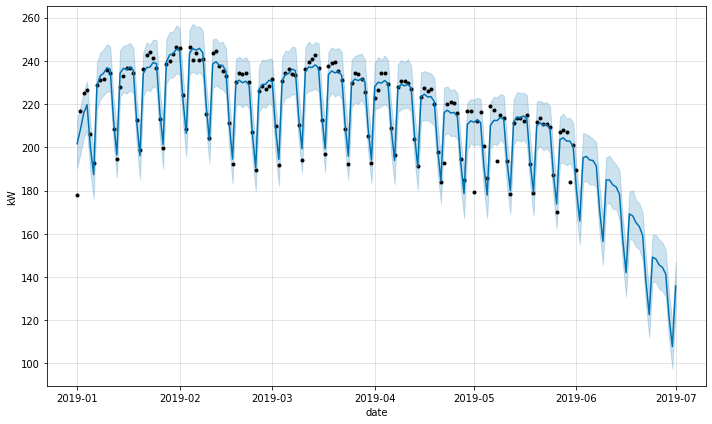

In [95]:
client_id = '70079c4dff9f801c341b0a74d6ff22f8'
generate_prediction(client_id)

cluster_id 5
RMSE 20.92193077157751


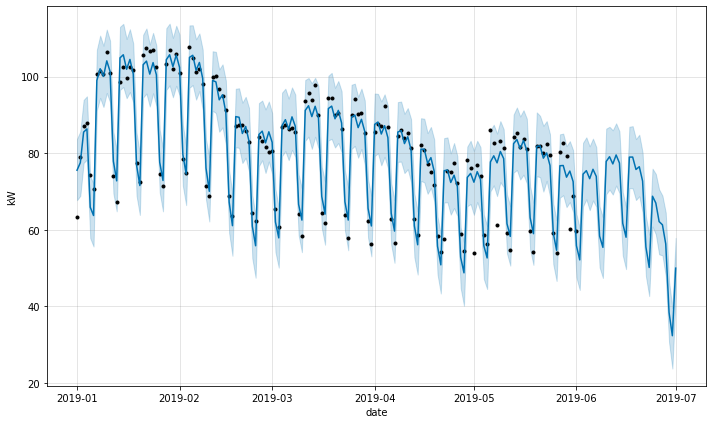

In [96]:
client_id = '336adcb85162909390c8ef800ec9bea7'
generate_prediction(client_id)

cluster_id 10
RMSE 147.13414977226333


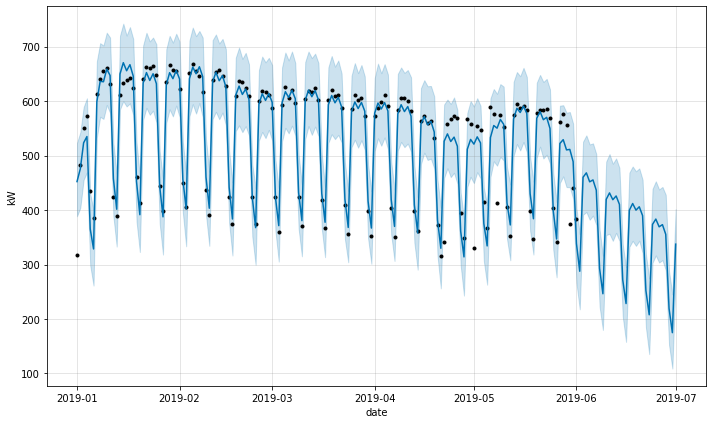

In [97]:
client_id = '236bb8209514bdd27b04d3ec7b19e410'
generate_prediction(client_id)

# Powerpoint presentation

https://docs.google.com/presentation/d/1Ia4OYr9rPRgHjE_Q90OC1R6umDtUqwrhmG5Z2ab8szc/edit?usp=sharing